In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [7]:
# Drawdown implementation using Mean Reversion Strategy 
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2024-12-31')[['Close']]
df.columns = ['price']
df.dropna(inplace=True)

C:\Users\Alqama\AppData\Local\Temp\ipykernel_11704\1863188571.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01', end='2024-12-31')[['Close']]
[*********************100%***********************]  1 of 1 completed


In [9]:
window = 20
z_entry = 1.5
z_exit = 0.5

df['mean'] = df['price'].rolling(window).mean()
df['std'] = df['price'].rolling(window).std()
df['z_score'] = (df['price'] - df['mean']) / df['std']

df['position'] = 0
df.loc[df['z_score'] < -z_entry, 'position'] = 1
df.loc[df['z_score'] > z_entry, 'position'] = -1
df.loc[abs(df['z_score']) < z_exit, 'position'] = 0

df['returns'] = df['price'].pct_change()
df['strategy'] = df['position'].shift(1) * df['returns']
df.dropna(inplace=True)

In [15]:
def apply_drawdown_limit(df, max_drawdown = 0.1):
    equity = [100_000]
    peak = [100_000]
    active = True

    for i in range(1, len(df)):
        daily_return = df['strategy'].iloc[i] if active else 0
        next_value = equity[-1] * (1 + daily_return)
        equity.append(next_value)
        peak.append(max(peak[-1], next_value))

    
        drawdown = (next_value - peak[-1]) / peak[-1]
        if drawdown < -max_drawdown:
            active = False

    df['equity_curve'] = equity
    df['peak'] = peak
    df['drawdown'] =(df['equity_curve'] - df['peak']) / df['peak']
    return df

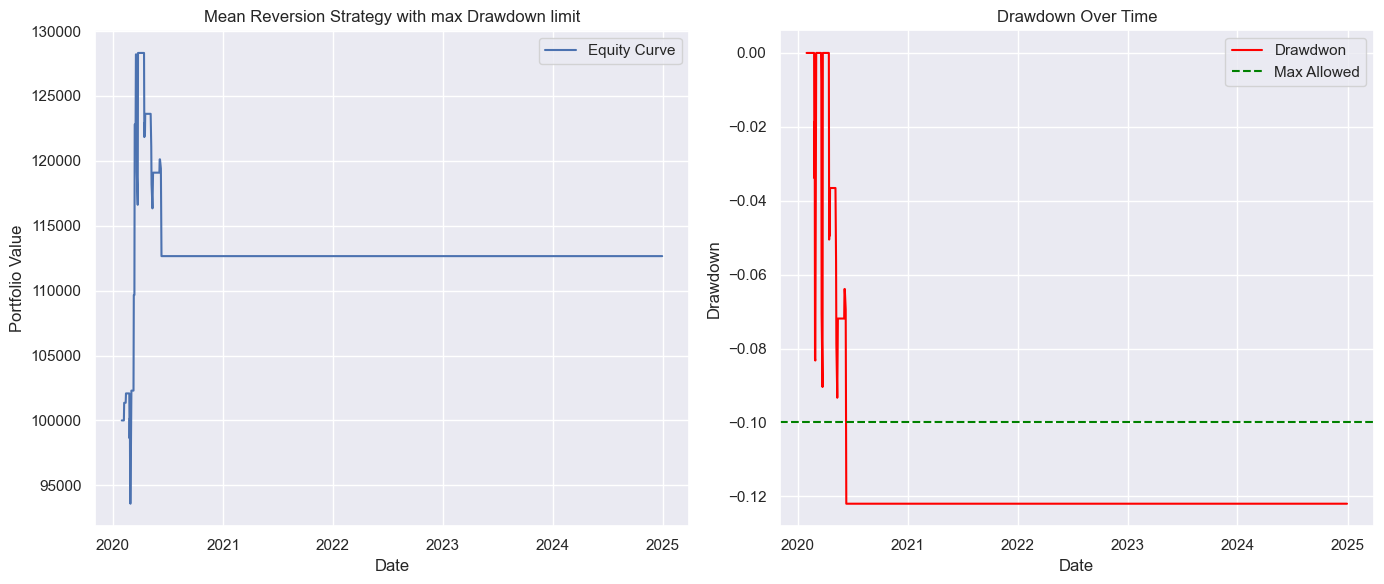

In [27]:
df = apply_drawdown_limit(df, max_drawdown = 0.1)

plt.figure(figsize=(14, 6))

# Equity curve
plt.subplot(1, 2, 1)
plt.plot(df['equity_curve'], label = 'Equity Curve')
plt.title("Mean Reversion Strategy with max Drawdown limit")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()

# Drawdown Plot
plt.subplot(1, 2, 2)
plt.plot(df['drawdown'], color='red', label = 'Drawdwon')
plt.title("Drawdown Over Time")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.axhline(-0.1, color = 'green', linestyle = '--', label = 'Max Allowed')
plt.legend()

plt.tight_layout()
plt.show()